Try to see how similar the output of the GAN is with respect to the ground truth, to see if the model is overfitted or underfitted.
GANs are hard to evaluate in general -> https://stats.stackexchange.com/questions/482653/what-is-the-stop-criteria-of-generative-adversarial-nets

In [2]:
import os
import glob

from PIL import Image
# https://pypi.org/project/ImageHash/
import imagehash
import numpy as np

from matplotlib import pyplot as plt

In [3]:
def hash_image(img_path: str, method: str = 'average', hash_size: int=8) -> str:
    # implement the hashing methods of choice here
    img = Image.open(img_path)
    if method == 'average':
        hash_ = imagehash.average_hash(img, hash_size=hash_size)
    elif method == 'perceptual':
        hash_ = imagehash.phash(img, hash_size=hash_size)
    else:
        raise ValueError(f'Unknown method: {method}')
    img.close()
    
    return str(hash_)  # important! return the string version of it

In [4]:
def get_all_punk_files(punks_folder: str, glob_by: str='punk*.png') -> list:
    return glob.glob(os.path.join(punks_folder, glob_by))

In [5]:
def hash_ground_truth(punks_folder: str, method: str = 'average', hash_size: int = 8) -> dict:
    ground_truth = {}
    for punk_file in get_all_punk_files(punks_folder):
        h_ = hash_image(punk_file, method, hash_size)
        if h_ in ground_truth:
            # print(f'Hash collision! {punk_file} with {ground_truth[h_]}')
            pass
        else:
            ground_truth[h_] = []
        ground_truth[h_].append(punk_file)
    return ground_truth

In [6]:
punks_folder = './punks'
method = 'perceptual'
hash_size = 12

gt = hash_ground_truth(punks_folder, method, hash_size)

If the following number is too low then the hashing technique might be too aggressive...

In [7]:
print(f'There are {len(gt)} buckets in the ground truth of '
      f'{len(get_all_punk_files(punks_folder))} punks')

There are 8926 buckets in the ground truth of 10000 punks


In [8]:
# check if hashing actually works
# poor man's unit test here:
punk_1 = os.path.join(punks_folder, 'punk_1.png')

assert punk_1 in gt[hash_image(punk_1, method, hash_size)]

In [9]:
gt_key_distro = list(sorted(gt.keys()))
base_distro = [gt_key_distro.index(hash_image(punk_file, method, hash_size))
               for punk_file in get_all_punk_files(punks_folder)]

(Hash calibration was already done in Training analysis of 2020-11-5, removing it here)

# Analysis of training with 1000 epochs (2021-11-16), without oversampling, etc

### Check training metrics first

I am not sure exactly: what is the generator loss and how should it behave?
https://developers.google.com/machine-learning/gan/loss
Am I right that the generator loss should increase and the discriminator should decrease?

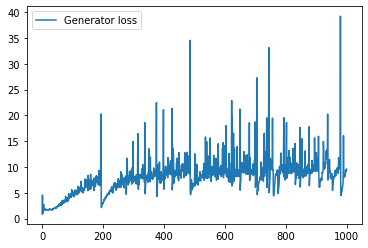

In [12]:
import pandas as pd

file = pd.read_csv("run-16-11_training.txt")
plot = file.plot.line(y=['Generator loss'])

plt.show()

Not really stable, according to this it should be close to 0.5 for both : https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

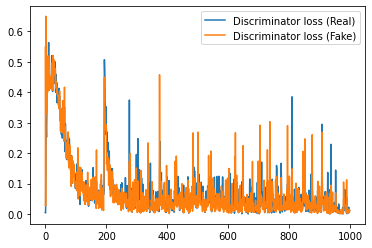

In [13]:
file = pd.read_csv("run-16-11_training.txt")
plot = file.plot.line(y=['Discriminator loss (Real)',
                         'Discriminator loss (Fake)'])

plt.show()

If accuracy fake is always close to 1.0 then it means the generated images are really different from the real ones I guess.
Accuracy should be around 0.7 for both types according to the above link!

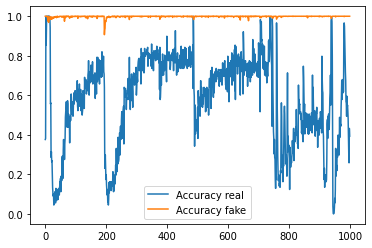

In [144]:
plot = file.plot.line(y=['Accuracy real', 'Accuracy fake'])

plt.show()

### Check image hashing metrics

In [15]:
iterations = range(1, 1000, 30)

In [16]:
gt_key_distro = list(sorted(gt.keys()))
    
def calculate_metrics(output_folder: str) -> dict:
    n_collisions = 0
    n_new = 0
    total_punks = 0

    new_punk_files = []

    own_collisions = set()

    collisions_distro = []

    for punk_file in get_all_punk_files(output_folder, 'result*png'):
        total_punks += 1
        h_ = hash_image(punk_file, method, hash_size)
        own_collisions.add(h_)
        if h_ in gt:
            n_collisions += 1
            collisions_distro.append(gt_key_distro.index(h_))
        else:
            n_new += 1
            new_punk_files.append(punk_file)

    return {
        'new_punks': n_new,
        'similar_punks': n_collisions,
        'own_similar_punks': total_punks - len(own_collisions),
        'similar_distro_spread': (len(set(collisions_distro))
                                  if len(collisions_distro) > 0 else 0),
        'similar_avg_group_size': (len(collisions_distro) / len(set(collisions_distro))
                                   if len(collisions_distro) > 0 else 0),
        'collisions_distro': collisions_distro,
        'output_folder': output_folder
    }

In [17]:
df_data = [calculate_metrics(f'train_analysis_2021_11_17/{iteration}')
           for iteration in iterations]

In [18]:
import pandas as pd

df = pd.DataFrame(df_data)

<AxesSubplot:>

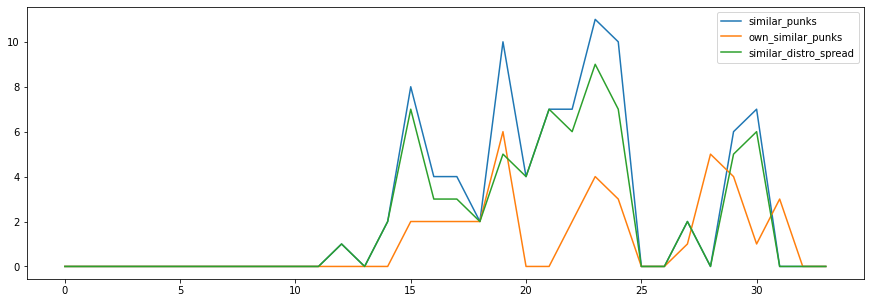

In [19]:
df[['similar_punks', 'own_similar_punks', 'similar_distro_spread']].plot(figsize=(15,5))

## Find the optimal training point

Difficult to say how, because the trianing does not look stable at all.
But I think what we are looking for is:
* Low value for 'own_similar_punks' such that the output looks varied
* Medium value for 'similar_punks' such that the output looks a bit like real p unks
* 'similar_punks' almost equal to 'similar_distro_spread' such that the model learned to imitate different classes of punks

In [25]:
df = df[df['similar_punks'] > 0]
df = df[(df['similar_punks'] - df['similar_distro_spread']) < 2]

df[['output_folder', 'similar_punks', 'own_similar_punks', 'similar_distro_spread']]

,output_folder,similar_punks,own_similar_punks,similar_distro_spread
12,train_analysis_2021_11_17/361,1,0,1
14,train_analysis_2021_11_17/421,2,0,2
15,train_analysis_2021_11_17/451,8,2,7
16,train_analysis_2021_11_17/481,4,2,3
17,train_analysis_2021_11_17/511,4,2,3
18,train_analysis_2021_11_17/541,2,2,2
20,train_analysis_2021_11_17/601,4,0,4
21,train_analysis_2021_11_17/631,7,0,7
22,train_analysis_2021_11_17/661,7,2,6
27,train_analysis_2021_11_17/811,2,1,2


In [26]:
best_row = df[df.index == 30].to_dict('records')[0]

In [27]:
idx = best_row['output_folder'].split('/')[1]

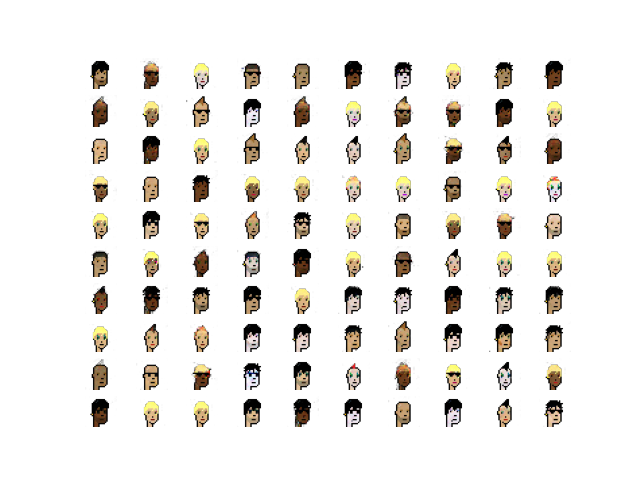

In [28]:
Image.open(f'train_analysis_2021_11_17/run-16-11_e_{idx}.png')